In [1]:
import pandas as pd
fhlo = pd.read_csv("../../input_data/fully_hand_labelled_output.csv")

In [2]:
fhlo.Roken = fhlo.Roken.astype('category').cat.codes
fhlo.Alcohol = fhlo.Alcohol.astype('category').cat.codes
fhlo.Drugs = fhlo.Drugs.astype('category').cat.codes
fhlo["label"] = fhlo.Roken
fhlo2 = fhlo[["text", "label"]]

In [3]:
train=fhlo2.sample(frac=0.8,random_state=200)
test=fhlo2.drop(train.index)

In [4]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [5]:
from datasets import load_dataset

dataset = load_dataset(
  'csv',
  data_files=['test.csv'],
  delimiter=",",
  column_names=['text', 'label'],
  skiprows=[0, 1583]
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/hjmuizelaar/.cache/huggingface/datasets/csv/default-bbc7b1379ec86ccb/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
from transformers import RobertaTokenizer, RobertaForMaskedLM, RobertaForSequenceClassification, AdamW, DataCollatorForLanguageModeling, Trainer, TrainingArguments

tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")

In [8]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis", model="Hielke/finetuned_RobBERT", tokenizer="pdelobelle/robbert-v2-dutch-base")


In [18]:
test_text = "17.	roken: + gestopt sinds april, rookte voorheen 2 sigaretten per dag; Gaat erg goed."
classifier(test_text)

[{'label': 'LABEL_3', 'score': 0.9969111084938049}]

In [19]:
test

,text,label
2,Conclusie: \tNormale nacontrole. Kijkt goed te...,2
17,Conclusie: \tSamenvatting ABCDE: ICC bij traum...,2
37,"Beloop: \tStaat gepland voor TC, echter nummer...",2
40,Beloop: \tLab belt: materiaal van 24-uurs urin...,2
48,Beloop: \tBeloop: Reguliere controle na ACDF C...,1
...,...,...
4678,Samenvatting: \tVoorgeschiedenis: in verleden ...,0
4682,"Anamnese: \tNog steeds hielspoor links, heeft ...",0
4688,Reden van komst / Verwijzing: \tReden verwijzi...,0
4691,Anamnese: \t Verkort consult: Aandachtspunten ...,1


In [20]:
def predict(x):
    pred_y = classifier(x['text'][:512])
    if len(x['text']) <= 512:
        return pred_y[0]['label']
    highest_score = pred_y[0]['score']
    if pred_y[0]['label'] == 'LABEL_2':
        highest_score = 0
    for z in range(512, len(x['text']), 512):
        sliced_text = x['text'][z:(z+512)]
        new_pred_y = classifier(sliced_text)
        if new_pred_y[0]['label'] != 'LABEL_2':
            if new_pred_y[0]['score'] > highest_score:
                pred_y = new_pred_y
                highest_score = new_pred_y[0]['score']
    return pred_y[0]['label']

In [21]:
test['prediction'] = test.apply(lambda row: predict(row), axis=1)
test['prediction'] = test['prediction'].str[-1]
test['prediction'] = test['prediction'].astype('int')

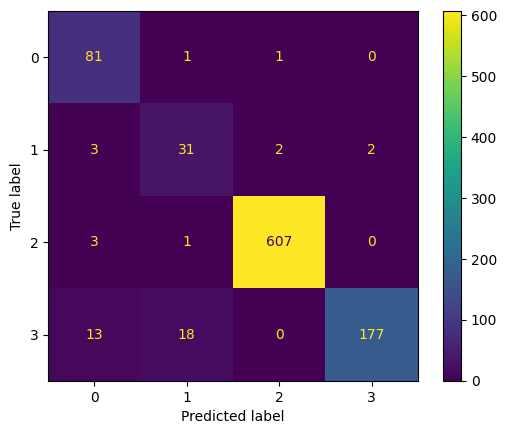

              precision    recall  f1-score   support

           0       0.81      0.98      0.89        83
           1       0.61      0.82      0.70        38
           2       1.00      0.99      0.99       611
           3       0.99      0.85      0.91       208

    accuracy                           0.95       940
   macro avg       0.85      0.91      0.87       940
weighted avg       0.96      0.95      0.96       940



In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import matplotlib.pyplot as plt

cm = confusion_matrix(test['label'], test['prediction'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(metrics.classification_report(test['label'], test['prediction']))

In [23]:
test.to_csv('robbert-haga_smoking_predictions.csv')